# Prediction of LendingClub loan defaulters
#### RIHAD VARIAWA
#### 09-03-2019

The dataset used for this analysis can be found using the following [link](https://www.kaggle.com/wendykan/lending-club-loan-data)

### About LendingClub:
LendingClub is a US peer-to-peer lending company, headquartered in San Francisco, California. It was the first peer-to-peer lender to register its offerings as securities with the Securities and Exchange Commission (SEC), and to offer loan trading on a secondary market. Lending Club is the world's largest peer-to-peer lending platform.The company claims that $ 15.98 billion in loans had been originated through its platform up to December 31, 2015.

Lending Club enables borrowers to create unsecured personal loans between $$1,000 and $ 40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.


### About the Dataset
These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 890 thousand observations and 75 variables. A data dictionary is provided in a separate file. k

### Purpose of this analysis
Build a machine learning algorithm to predict loan defaulters based on certain variables present in the dataset, so we can correctly identifying defaulters (True positives) of  the lender **lending club** in order to consider whether existing borrowers  are fit for additional loans or not in the future.


## How Lending Club Works?
<img src="http://echeck.org/wp-content/uploads/2016/12/Showing-how-the-lending-club-works-and-makes-money-1.png">

### Loading Packages
We will start by importing the packages that will be used throughout the analysis

In [0]:
# data manipulation and prepocessing
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox

In [0]:
# read the dataset
df = pd.read_csv('../lending_club/loan.csv.zip', low_memory=False)
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

In [0]:
# find the count and percentage of values that are missing in the dataframe.
df_null = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})

# print columns with null count more than 0
df_null[df_null['Count'] > 0] 

,Count,Percent
emp_title,51462,5.799326
emp_length,44825,5.051393
annual_inc,4,0.000451
desc,761351,85.797726
title,152,0.017129
delinq_2yrs,29,0.003268
earliest_cr_line,29,0.003268
inq_last_6mths,29,0.003268
mths_since_last_delinq,454312,51.197065
mths_since_last_record,750326,84.555303


As you can see, there are a lot of columns which have huge chunk of data missing. These columns are not necessary for our 
analysis. The following part will drop any columns where 80% or more data is missing. This will help us clean the Dataset 
a little bit.

In [0]:
df1 = df.dropna(axis=1, thresh=int(0.80*len(df)))

In [0]:
df1.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,Jan-2015,171.62,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,Apr-2013,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,Jun-2014,649.91,Jan-2016,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN


Now that we explored the whole dataframe easily, we will now select the columns that are necessary for our analysis.

In [0]:
df_LC = df1.filter(['loan_amnt','term','int_rate','installment','grade','sub_grade','emp_length','home_ownership',
                    'annual_inc','verification_status','purpose','dti','delinq_2yrs','loan_status'])
df_LC.dtypes

loan_amnt              float64
term                    object
int_rate               float64
installment            float64
grade                   object
sub_grade               object
emp_length              object
home_ownership          object
annual_inc             float64
verification_status     object
purpose                 object
dti                    float64
delinq_2yrs            float64
loan_status             object
dtype: object

### Finding the correlation between variables
We will now look at the correlation structure between our variables that we selected above. This will tell us about any dependencies between different variables and help us reduce the dimensionality a little bit more

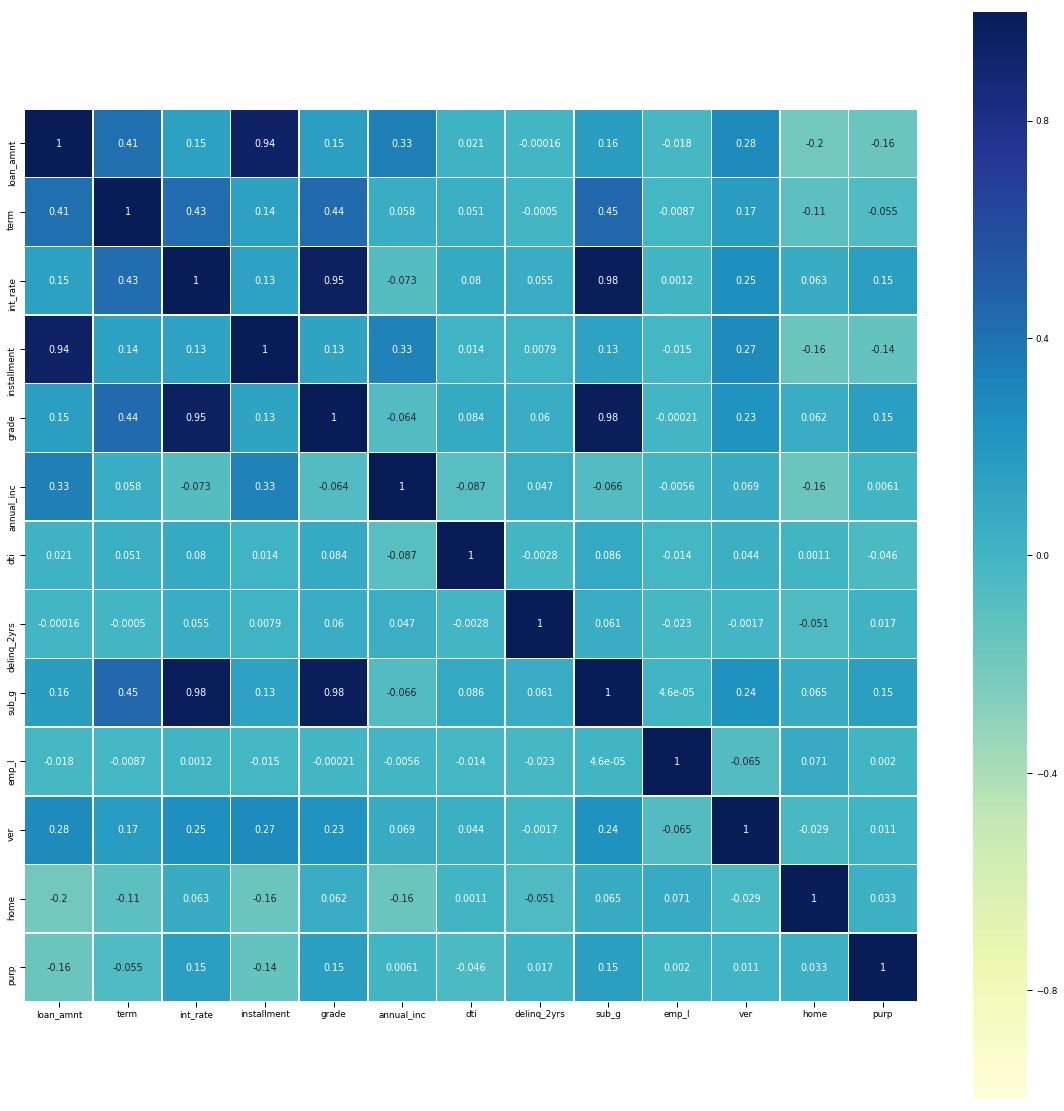

In [0]:
plt.figure(figsize=(20,20))
sns.set_context("paper", font_scale=1)

# find the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df_LC.assign(grade=df_LC.grade.astype('category').cat.codes,
                         sub_g=df_LC.sub_grade.astype('category').cat.codes,
                         term=df_LC.term.astype('category').cat.codes,
                        emp_l=df_LC.emp_length.astype('category').cat.codes,
                         ver =df_LC.verification_status.astype('category').cat.codes,
                        home=df_LC.home_ownership.astype('category').cat.codes,
                        purp=df_LC.purpose.astype('category').cat.codes).corr(), 
                         annot=True, cmap='YlGnBu',vmin=-1, vmax=1, square=True, linewidths=0.5)

It can be seen from the plot above that loan amount and installment have a very high correlation amongst each other (0.94). This is intuitive since a person who takes a large sum of loan would require extra time to repay it back. Also, interest rate, sub grade and grade have a very high correlation between them. This is obvious since interest rate is decided by grades once the grades are decided, a subgrade is assigned to that loan (leading to high correlation).

Let's drop the three categories alongwith term and verification status(since it doesn't provide any valuable info) for further analysis.


In [0]:
df_LC.drop(['installment','grade','sub_grade','verification_status','term']
           , axis=1, inplace = True)

In [0]:
# print the count and null values in the dataframe
dflc_null = pd.DataFrame({'Count': df_LC.isnull().sum(), 'Percent': 100*df_LC.isnull().sum()/len(df_LC)})
dflc_null[dflc_null['Count'] > 0]

,Count,Percent
emp_length,44825,5.051393
annual_inc,4,0.000451
delinq_2yrs,29,0.003268


In [0]:
# dropping the null rows since we have sufficient amount of data and there is no need to fill the null values.
df_LC.dropna(axis=0)

,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,purpose,dti,delinq_2yrs,loan_status
0,5000.0,10.65,10+ years,RENT,24000.00,credit_card,27.65,0.0,Fully Paid
1,2500.0,15.27,< 1 year,RENT,30000.00,car,1.00,0.0,Charged Off
2,2400.0,15.96,10+ years,RENT,12252.00,small_business,8.72,0.0,Fully Paid
3,10000.0,13.49,10+ years,RENT,49200.00,other,20.00,0.0,Fully Paid
4,3000.0,12.69,1 year,RENT,80000.00,other,17.94,0.0,Current
5,5000.0,7.90,3 years,RENT,36000.00,wedding,11.20,0.0,Fully Paid
6,7000.0,15.96,8 years,RENT,47004.00,debt_consolidation,23.51,0.0,Current
7,3000.0,18.64,9 years,RENT,48000.00,car,5.35,0.0,Fully Paid
8,5600.0,21.28,4 years,OWN,40000.00,small_business,5.55,0.0,Charged Off
9,5375.0,12.69,< 1 year,RENT,15000.00,other,18.08,0.0,Charged Off


In [0]:
# print unique statuses in the loan status column (dependent variable)
df_LC['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

### Distribution of the loan status values
Let us now see how the values in the status column are distributed. We will plot an histogram of values against count of times the status appears on the dataframe

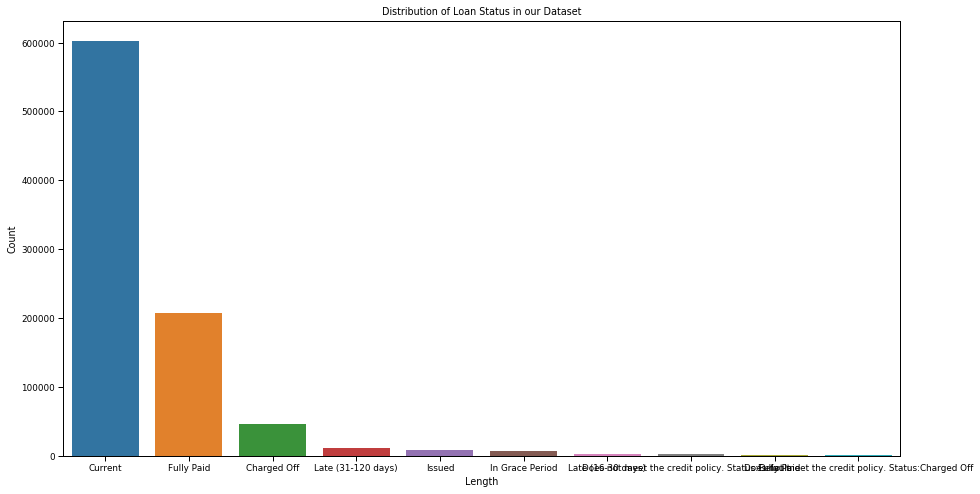

In [0]:
m = df_LC['loan_status'].value_counts()
m = m.to_frame()
m.reset_index(inplace=True)
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(15,8))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset")
plt.show()

As you can see, we have a lot of loans which are current with fair amount of fully paid loans. other categories (including) default have a really low number. This means the data is imbalanced and we might need to do something about this later in the analysis. For now we will drop all the columns except 'Fully Paid', 'Default' and 'Charged off'. We will also merge 'Charged off' and 'Default' together meaning that anyone who fell into this category defaulted their loan. The following two parts tries to implement this.

In [0]:
df_LC = df_LC[df_LC.loan_status != 'Current']
df_LC = df_LC[df_LC.loan_status != 'In Grace Period']
df_LC = df_LC[df_LC.loan_status != 'Late (16-30 days)']
df_LC = df_LC[df_LC.loan_status != 'Late (31-120 days)']
df_LC = df_LC[df_LC.loan_status != 'Does not meet the credit policy. Status:Fully Paid']
df_LC = df_LC[df_LC.loan_status != 'Does not meet the credit policy. Status:Charged Off']
df_LC = df_LC[df_LC.loan_status != 'Issued']

In [0]:
df_LC['loan_status'] = df_LC['loan_status'].replace({'Charged Off':'Default'})
df_LC['loan_status'].value_counts()

Fully Paid    207723
Default        46467
Name: loan_status, dtype: int64

We will now encode the two categories listed above as 0 or 1 for our analysis. This will help us in predicting whether a person defaulted their loan or not. 0 means he deaulted and 1 means he paid off his loan.

In [0]:
df_LC.loan_status=df_LC.loan_status.astype('category').cat.codes
df_LC.delinq_2yrs=df_LC.delinq_2yrs.astype('category').cat.codes
df_LC.head()
df_LC['loan_status'].value_counts()
#df_LC = pd.get_dummies(df_LC, drop_first=True)
#df_LC

1    207723
0     46467
Name: loan_status, dtype: int64

In [0]:
df_LC.dtypes

loan_amnt         float64
int_rate          float64
emp_length         object
home_ownership     object
annual_inc        float64
purpose            object
dti               float64
delinq_2yrs          int8
loan_status          int8
dtype: object

### Transformation
Before training the data, we would first transform the data to account for any skewness in the variable distribution. Various transformation techniques ranging from log transform to power transformation are available. For our analysis, we'll be using Box-cox transformation. It is used to modify the distributional shape of a set of data to be more normally distributed so that tests and confidence limits that require normality can be appropriately used.

In [0]:
numerical = df_LC.columns[df_LC.dtypes == 'float64']
for i in numerical:
    if df_LC[i].min() > 0:
        transformed, lamb = boxcox(df_LC.loc[df[i].notnull(), i])
        if np.abs(1 - lamb) > 0.02:
            df_LC.loc[df[i].notnull(), i] = transformed

### One Hot Encoding
Since we have some categorical variables for the analysis and the machne learning algorithms doesn't take categorical and string variables directly, we have to creat dummy variables for them. We can either encode them using label encoder available for python, but it would be wrong in our analysis since a lot of these variables have multiple categories. Just using weights can cause discrepencies in the algorithm. Instead, we will one hot encode these so that we have a 1 wherever that category turns up and 0 otherwise. This will also create seperate columns for each level of category. Also, we'll be dropping one of the categories so that we have N-1 columns instead of N.

In [0]:
df_LC = pd.get_dummies(df_LC, drop_first=True)

Now splitting the data using scikitlearn's train_test_split and using 60% data for training and 40% for testing.

In [0]:
traindata, testdata = train_test_split(df_LC, stratify=df_LC['loan_status'],test_size=.4, random_state=17)
testdata.reset_index(drop=True, inplace=True)
traindata.reset_index(drop=True, inplace=True)

We'll now scale the data so that each column has a mean of zero and unit standard deviation. Xunb (unbalanced set) and yunb are the independent and target variable.

In [0]:
sc = StandardScaler()
Xunb = traindata.drop('loan_status', axis=1)
yunb = traindata['loan_status']
numerical = Xunb.columns[(Xunb.dtypes == 'float64') | (Xunb.dtypes == 'int64')].tolist()
Xunb[numerical] = sc.fit_transform(Xunb[numerical])

In [0]:
# preview the shape of training data
yunb.shape

(152514,)

### Model Selection

We are now ready to build some models. The following would be our approach for building and selecting the best model:

1. Build a model on the imbalance dataset we got from data cleaning.
2. Balance the dataset by using equal amount of default and 'fully paid' loans.

#### Trying the Unbalanced Dataset

Let's first try the unbalanced dataset.The function below computes the receiver operating characteristic (ROC) curves for each of the models. This function will be called later in the analysis.

In [0]:
# roc curve to find a good model that optimizes the trade off between
# the False Positive Rate (FPR) and True Positive Rate (TPR)
def createROC(models, X, y, Xte, yte):
    false_p, true_p = [], [] # false postives and true positives

    for i in models.keys():  # dict of models
        models[i].fit(X, y)

        fp, tp, threshold = roc_curve(yte, models[i].predict_proba(Xte)[:,1]) # roc_curve function

        true_p.append(tp)
        false_p.append(fp)
    return true_p, false_p # returning the true postive and false positive

Let's try some models on the train dataset With 3 fold cross validation. We are going to use the following 4 machine learning algorithms:
1. Linear Discriminant Analysis
2. Multinomial Naive Bayes
3. Random Forest (tree based model)
4. Logistic Regression

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1)}

unbalset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xunb - np.min(Xunb) + 1,
                                    yunb, cv=3)
    unbalset[i] = scores
    print(i, scores, np.mean(scores))

/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA [0.81750231 0.81720367 0.81773118] 0.8174790526041468
MNB [0.81718759 0.81720367 0.81720007] 0.8171971098553484
RF [0.81211275 0.81185334 0.81411177] 0.8126926183761549


/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR [0.81726627 0.81773477 0.81767217] 0.8175577350662624


Looks like Logistic regression provides the best estimate and almost all of the models giving the same results. Because of the issue of collinearity in LDA, we are going to ignore that.

Now creating the test set for the analysis and scaling it.

In [0]:
Xte = testdata.drop('loan_status', axis=1)
yte = testdata['loan_status']
numerical = Xte.columns[(Xte.dtypes == 'float64') | (Xte.dtypes == 'int64')].tolist()
Xte[numerical] = sc.fit_transform(Xte[numerical])

Computing the ROC curves for the models and finding the true positive and false positives.

In [0]:
tp_unbalset, fp_unbalset = createROC(models, Xunb - np.min(Xunb) + 1, yunb, Xte - np.min(Xte) + 1, yte)

/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fitting LR to the test set.

In [0]:
model =  LogisticRegression(C=1)
model.fit(Xunb, yunb)
predict = model.predict(Xte) # prediction of Xte which can be used to test against yte (testdata values or true values of y)

/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
m = yte.to_frame()
m['loan_status'].value_counts()

1    83089
0    18587
Name: loan_status, dtype: int64

We will now plot the cross-validation scores, ROC curves and confusion matrix of random forest model. X axis is the true value and Y axis is the predicted value. 

(0.0, 2.0, 2.0, 0.0)

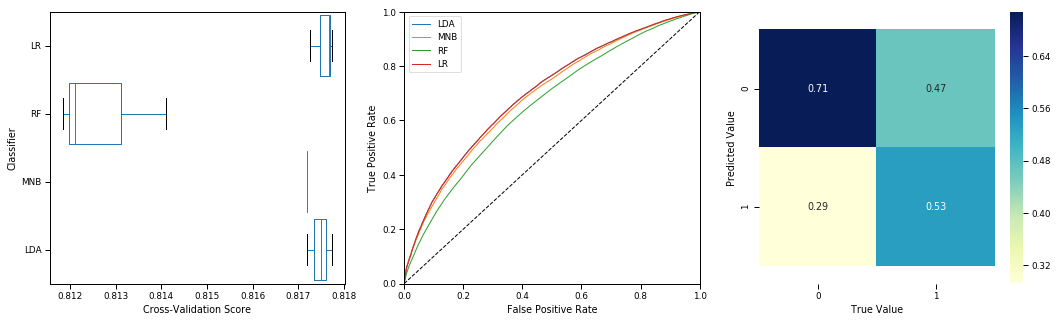

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

ax = pd.DataFrame(unbalset).boxplot(widths=(0.9,0.9,0.9,0.9), grid=False, vert=False, ax=axes[0])
ax.set_ylabel('Classifier')
ax.set_xlabel('Cross-Validation Score')

for i in range(0, len(tp_unbalset)):
    axes[1].plot(fp_unbalset[i], tp_unbalset[i], lw=1)

axes[1].plot([0, 1], [0, 1], '--k', lw=1)
axes[1].legend(models.keys())
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='YlGnBu', ax=axes[2]);
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

The cross-validation scores and ROC curves suggest the Logistic Regression is the best model, though the MNB and linear discriminant analysis models are pretty close behind. If we look at the confusion matrix, though, we see a big problem.The model can predict who are going to pay off the loan with a good accuracy of 99% but cannot predict who are going to default. The true positive rate of default (0 predicting 0) is almost 0. Since our main goal is to predict defaulter's, we have to do something about this. 

The reason this is happening could be because of high imbalance in our dataset and the algorithm is putting everything into 1. We have to chose a new prediction threshold according to the sensitivity and specificity of the model. This will create some balance in predicting the binary outcome. Let's look at the plots below.

In [0]:
fp, tp, threshold = roc_curve(yte, model.predict_proba(Xte)[:,1]) #getting false and true positive from test set

Text(0, 0.5, 'True Positive & False Positive Rates')

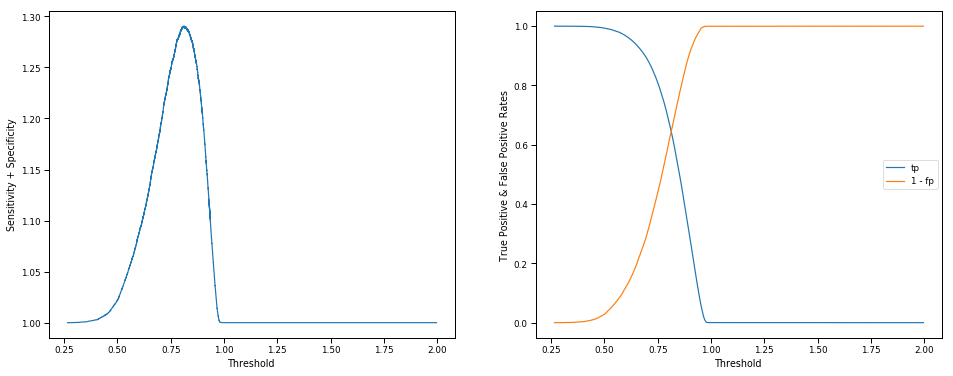

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].plot(threshold, tp + (1 - fp))
ax[0].set_xlabel('Threshold')
ax[0].set_ylabel('Sensitivity + Specificity')

ax[1].plot(threshold, tp, label="tp")
ax[1].plot(threshold, 1 - fp, label="1 - fp")
ax[1].legend()
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('True Positive & False Positive Rates')

In [0]:
# finding the optimal threshold for the model 
function = tp + (1 - fp)
index = np.argmax(function)

optimal_threshold = threshold[np.argmax(function)]
print('optimal threshold:', optimal_threshold)

optimal threshold: 0.8079914859607571


The optimal threshold above is where the the two graphs meet.

1. Sensitivity (also called the true positive rate, the recall, or probability of detection in some fields) measures the proportion of actual positives that are correctly identified as such (e.g., the percentage of sick people who are correctly identified as having the condition).

2. Specificity (also called the true negative rate) measures the proportion of actual negatives that are correctly identified as such (e.g., the percentage of healthy people who are correctly identified as not having the condition)

Now using this threshold for the model:

(0.0, 2.0, 2.0, 0.0)

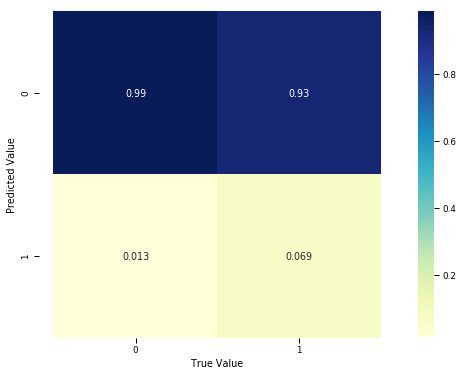

In [0]:
predict = model.predict_proba(Xte)[:,1]
predict = np.where(predict >= optimal_threshold, 1, 0)

fig, axes = plt.subplots(figsize=(8,6))

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='YlGnBu')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.axis('equal')

That's great! The optimum threshold for the classifier have increased out models prediction power of Default (0). Even now the model doesn't provide a lot of prediction power and we have to train the model again using a different algorithm with some tweaks.

### Part2 : Balancing the training dataset and creating a new model
Now we will try to use a balanced dataset with equal amount of zeroes and 1's. The following part does the same.

In [0]:
y_default = traindata[traindata['loan_status'] == 0]
n_paid = traindata[traindata['loan_status'] == 1].sample(n=len(y_default), random_state=17) # chosing equal amount of 1's

# creating a new dataframe for balanced set
data = y_default.append(n_paid) 

# creating the independent and dependent array
Xbal = data.drop('loan_status', axis=1)
ybal = data['loan_status']

In [0]:
# scaling it again
numerical = Xbal.columns[(Xbal.dtypes == 'float64') | (Xbal.dtypes == 'int64')].tolist()
Xbal[numerical] = sc.fit_transform(Xbal[numerical])

Training the model on the balanced set

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1)}

balset = {}
for i in models.keys():
    scores = cross_val_score(models[i], Xbal - np.min(Xbal) + 1,
                                    ybal, scoring='roc_auc', cv=3)
    balset[i] = scores
    print(i, scores, np.mean(scores))

/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA [0.69464012 0.70130022 0.69650983] 0.6974833900111825
MNB [0.68770514 0.69223586 0.68904917] 0.6896633859895305
RF [0.67215822 0.67331161 0.66824151] 0.671237112728265


/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/claireleannesaunders/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR [0.69468578 0.70130559 0.69655863] 0.6975166660896145


Even though we almost got the same result as before, This time we are going to select Random Forst method and will try to find the optimal number of trees using the gridsearchcv and try to make the predition based on this and lets see if there is any improvements in predicting 0's

In [0]:
model = RandomForestClassifier(n_estimators=100)
model.fit(Xbal, ybal)
predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

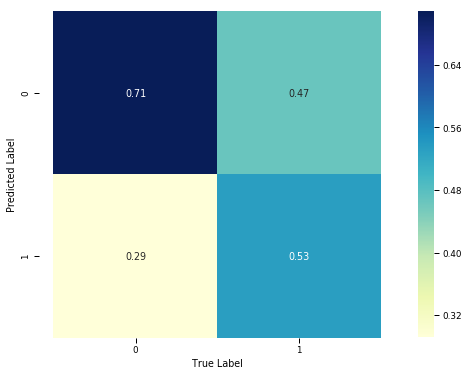

In [0]:
predict = model.predict(Xte)
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

That's a significant improvement over the last model that we built using Logistic regression. 

Let's find the optimum number of estimators for this model and use that for prediction. This time we are going to use 5 fold cross validation.

In [0]:
params = {'n_estimators': [50, 100, 200, 400, 600, 800]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params,
                                   scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(Xbal, ybal)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_estimators': 600}
0.6287661406025825


The best model has 600 trees

In [0]:
#r = pd.DataFrame()
#r['x'] = [i for i in params.values()][0]
#r['y'] = [i[1] for i in grid_search.cv_results_]
#ax = r.plot(x='x', y='y', legend=False, linestyle='-', marker='o', figsize=(8,6))
#ax.set_xlabel('n_estimators')
#ax.set_ylabel('5-Fold Cross-Validation Score')

As we can see, the score increases as we increase the number of estimators till 600 and then falls for 800 number of estimators.

We will use this to estimate to fit the model.

In [0]:
grid_search.best_estimator_.fit(Xbal, ybal)
predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

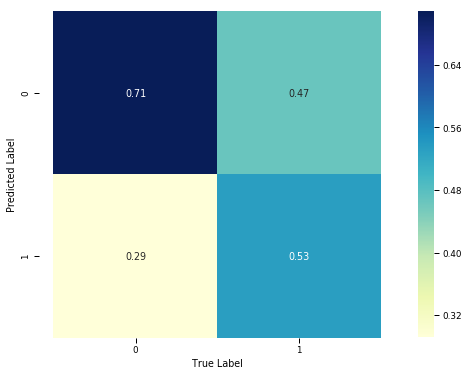

In [0]:
fig, axes = plt.subplots(figsize=(8,6))
cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)
ax = sns.heatmap(cm, annot=True, cmap='YlGnBu')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.axis('equal')

Interestingly, this gives us the same output as the previous model. Even now we have a good accuracy of 71% predicting defaluter's as defaulter's.

Since random forest is based on decision trees, we can also plot the variable importance. Variable importance tells us which variable had highest importance when predicting an outcome.

Text(0, 0.5, 'Relative Importance')

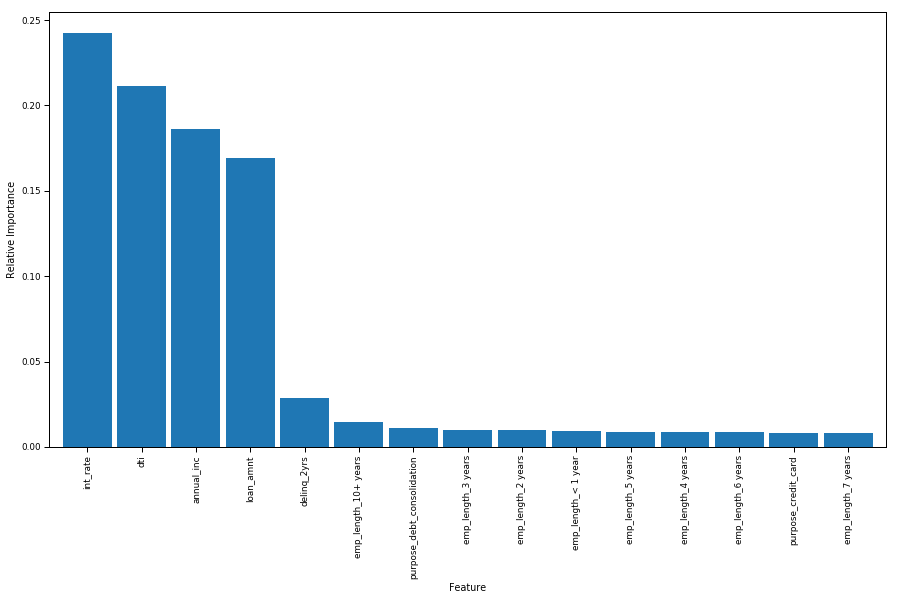

In [0]:
r = pd.DataFrame(columns=['Feature','Importance'])
ncomp = 15
r['Feature'] = feat_labels = Xbal.columns
r['Importance'] = model.feature_importances_
r.set_index(r['Feature'], inplace=True)
ax = r.sort_values('Importance', ascending=False)[:ncomp].plot.bar(width=0.9, legend=False, figsize=(15,8))
ax.set_ylabel('Relative Importance')

As you can see, interest rate followed by debt to income ratio,annual income, and loan amount are the most important features in predicting the defaulter's. Lending Club might want to use this as the metric for identifying people defaulting on their loans. 

### Conclusion
We have successfully built an machine learning algorithm to predict the people who might default on their loans. This can be further used by LendingClub for their analysis. Also, we might want to look on other techniques or variables to improve the prediction power of the algorthm. One of the drawbacks is just the limited number of people who defaulted on their loan in the 8 years of data (2007-2015) present in the dataset. We can use an updated dataframe which forecasts the next 3 years values (2015-2018) and see how many of the current loans were paid off or defaulted or even charged off. Then these new data points can be used for predicting them or even used to train the model again to improve its accuracy.

Since we had a lot of categorical data, we cannot apply PCA for dimensionality reduction. Because of this, we can try some different type of variable selection method like 'MULTIPLE CORRESPONDENCE ANALYSIS' to reduce the dimensionality and select the most important variables from the columns.

Since the algorithm puts around 47% of non-defaulters in the default class, we might want to look further into this issue to make the model more robust.